**Question/need:** Can we predict the success (gross revenues, revenues per budget dollar, and/or oscar nominations) of proposed low-budget films (< $10 million) based on its characteristics? Are there different predictive characteristics for success in terms of gross revenues vs. oscar nominations? 

**Movie data:** I'm planning on using all movies (1980 - 2016) from boxofficemojo to investigate the impact of various characteristics on success. If I have time, I would also like to incorporate other variables, such as google searches and wikipedia page views, as well as critic and general public rating information from rottentomatoes. 

**Characteristics of each movie and/or other entities:** I'd like to investigate as many characteristics as possible during my first pass to determine which ones have the greatest predictive impact, and then dig in deeper to these characteristics. The features I'm most interested in are: genre, release date (month, if before a holiday weekend, if during Christmas holiday, if during summer), star power (a score that accounts for actors, director, and producers), production budget, and if there the movie has some preexisting popularity, either through a novel/play adaptation or if there's a prequel. I'll also investigate other features such as runtime, rating, and franchise, but I have a hunch that these will have a smaller impact. 

In [542]:
'''TO DOS:
- oscars 3 model is the best w/ rsquared = 0.3
features = ['r_rating', 'recat_genre', 'hw_season', 'theaters3', 'runtime_mins', 'dom_roi_log']
ind = 'oscar_noms_log'

- get actor and director nominated for oscars up to date of movie release
- investigate interaction effects?
'''

'TO DOS:\n- clean up genres and rating\n- adjust budget for inflation'

In [69]:
# storing
import pickle

# exploratory analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from pandas.tools.plotting import scatter_matrix
import math

# regression
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures

from pprint import pprint

%matplotlib inline

### parse data

First, let's load the movie data into a dataframe and check the quality of our data.

In [39]:
with open('pickled_data/all-movies-data3.pkl', 'r') as picklefile:
    all_movies_data = pickle.load(picklefile)

In [40]:
movies = pd.DataFrame(all_movies_data)

Time to do some cleaning...

In [41]:
# rename cols
movies.rename(columns = {'1-title': 'title', 
                         '2-release_date': 'release_date', 
                         '3-closing_date': 'closing_date'}, inplace = True)

In [42]:
movies.head()

,title,release_date,closing_date,actors,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,intl_total_gross,oscar_noms,oscar_wins,producers,rating,runtime_mins,theaters,url,writers
0,The A-Team,2010-06-11,2010-09-16,"[Liam Neeson, Bradley Cooper, Sharlto Copley, ...",110000000,[Joe Carnahan],Fox,77222099,81884600,Action,177238796,0,0,"[Ridley Scott, Tony Scott, Alex Young]",PG-13,117,3544,ateam.htm,[Skip Woods]
1,A.C.O.D.,2013-10-04,2013-11-07,"[Adam Scott, Catherine O'Hara, Richard Jenkins...",NaN,,The Film Arcade,175705,177400,Comedy,NaN,0,0,[Teddy Schwarzman],PG-13,88,42,acod.htm,
2,A.I. Artificial Intelligence,2001-06-29,NaT,"[Haley Joel Osment, Frances O'Connor, Jude Law...",100000000,[Steven Spielberg],Warner Bros.,78616689,117091600,Sci-Fi,235926552,2,0,"[Kathleen Kennedy, Steven Spielberg]",PG-13,145,3242,ai.htm,
3,Aaja Nachle,2007-11-30,2007-12-20,,NaN,,Yash Raj,484108,593200,Foreign,6773493,0,0,,Unrated,145,66,aajanachle.htm,
4,Aarakshan,2011-08-12,2011-09-22,,NaN,,Reliance Big Pictures,651096,691300,Foreign,651096,0,0,,Unrated,NaN,91,aarakshan.htm,


In [43]:
by_genre = movies.groupby('genre')

In [44]:
# split actor, director, producer, writer columns
def get_person(peoplelist, i):
    '''Take a list of people and inde; return person at that index. Return blank if no list present.'''
    try:
        return peoplelist[i]
    except:
        return ''

def sep_people(df, person_type, num_people):
    '''For each column with list of people, split into n columns with one person in each column.
    Name new columns as person_type + n.
    
    Args:
    df -- name of dataframe
    person_type -- name of column (str)
    num_people -- number of columns to generate
    '''
    for n in range(num_people):
        df.loc[:, person_type + str(n+1)] = df.loc[:, person_type].apply(get_person, args=(n,))

# add seasons; rationale from http://www.boxofficemojo.com/seasonal/?chart=byseason
def get_season(date):
    '''Return season given month as int.'''
    months = (range(1, 13))
    seasons = ['winter', 'winter', 'spring', 'spring', 
           'summer', 'summer', 'summer', 'summer', 
           'fall', 'fall', 'holiday', 'holiday']
    seasons = dict(zip(months, seasons))
    try:
        return seasons[date.month]
    except:
        return ''
       
def recat(df, func, new_col, old_col):
    '''Recategorize variable in new column based on data in old col
    and provided function. 
    Args: 
    df -- data frame
    func -- function to apply
    new_col (str) -- name of new column (to store result of function)
    old_col (str) -- name of old column (on which to apply function)
    '''
    df[new_col] = df.loc[:, old_col].apply(func) 

# map raw genres to simple genres
def get_simple_genre(g):
    '''Recategorize raw genre into simple genre.'''
    raw_genres = tuple(by_genre.count().index)
    simple_genres = ['Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Animation', 'Comedy', 'Comedy', 'Comedy', 'Other', 
                 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 
                 'Documentary', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Foreign', 'Foreign', 'Foreign', 'Historical', 'Historical', 
                 'Horror', 'Horror', 'Horror', 'Other', 'Musical', 'Musical', 'None', 
                 'Historical', 'Historical', 'Historical', 'Historical', 'Historical', 
                 'Romance', 'Romance', 'Romance', 'Romance', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Sports', 'Sports', 'Sports', 'Sports',  'Crime_Thriller', 
                 'None', 'War', 'War', 'War', 'Western', 'Western']
    genres = dict(zip(raw_genres, simple_genres))
    try:
        return genres[g]
    except:
        return ''

def add_simple_genre(df):
    df['new_genre'] = df.loc[:, 'genre'].apply(get_simple_genre)
    
# clean up ratings
def get_clean_rating(r):
    rm_ratings = ['Unknown', 'Unrated', 'None', 'Not Yet Rated']
    return '' if r in rm_ratings else r

def clean_rating(df, func, new_col):
    '''Add new column to df with cleaned up rating. 
    Args:
    df -- df to work on
    func -- function to apply
    new col (str) -- name of new column to create for cleaned up rating
    '''
    df[new_col] = df.loc[:, 'rating'].apply(func)
    
# add roi
def add_roi(df):
    df['dom_roi'] = df.loc[:, 'dom_total_gross'] / df.loc[:, 'budget']
    df['intl_roi'] = df.loc[:, 'intl_total_gross'] / df.loc[:, 'budget']
    
# add total time in theaters - not necessary if we have theaters?
def add_in_theaters_time(df):
    try:
        df['time_in_theaters'] = df.loc[:, 'closing_date'] - df.loc[:, 'release_date']
    except:
        df['time_in_theaters'] = ''

In [46]:
sep_people(movies, 'director', 3)
sep_people(movies, 'actors', 5)
sep_people(movies, 'writers', 2)
sep_people(movies, 'producers', 3)
recat(movies, get_season, 'season', 'release_date')
clean_rating(movies, get_clean_rating, 'clean_rating')

In [45]:
add_simple_genre(movies) # try not to rerun this guy, takes a while

In [47]:
# pickle the parsed df
with open('pickled_data/parsed-data3.pkl', 'w') as picklefile:
    pickle.dump(movies, picklefile)

In [3]:
with open('pickled_data/parsed-data3.pkl', 'r') as picklefile:
    movies = pickle.load(picklefile)

In [49]:
movies.columns

Index([u'title', u'release_date', u'closing_date', u'actors', u'budget',
       u'director', u'distributor', u'dom_total_gross',
       u'domestic_total_adj_gross', u'genre', u'intl_total_gross',
       u'oscar_noms', u'oscar_wins', u'producers', u'rating', u'runtime_mins',
       u'theaters', u'url', u'writers', u'new_genre', u'director1',
       u'director2', u'director3', u'actors1', u'actors2', u'actors3',
       u'actors4', u'actors5', u'writers1', u'writers2', u'producers1',
       u'producers2', u'producers3', u'season', u'clean_rating'],
      dtype='object')

Since we're interested in budget data, let's check to see how many movies of the 16,100 total movies have budget data.

In [698]:
movies.budget.count()

2875

Only 2,874 out of 16,100 movies have budget data. That's only 17.9% of the entire dataset! Let's take a closer look at movies with budget data.

In [50]:
# drop movies without budget data 
only_budget = movies[pd.notnull(movies['budget'])]

In [51]:
### ONLY APPLICABLE TO MOVIES WITH BUDGETS

# adjust to 2015 dollars 
def get_infl_rate(startyear, endyear):
    '''Return inflation rate to 2015 dollars. 
    Args:
    startyear (float) -- start year
    endyear (int) -- end year
    Returns:
    infl (float) -- inflation rate
    '''
    cpi = pd.read_csv('cpi-data.csv')
    cpi.set_index('YEAR', inplace = True)
    if endyear > 2015:
        return float('NaN')
    else:
        try:
            cpiend = float(cpi.loc[endyear, 'AVE.'])
            cpistart = float(cpi.loc[int(startyear), 'AVE.'])
            infl = ((cpiend - cpistart) / cpistart) 
            return (1.0 + infl)
        except:
            return float('NaN')
    
def add_infl_rate(df):
    # add release year
    try:
        df['release_year'] = df['release_date'].apply(lambda x: x.year)
    except:
        df['release_year'] = None
    df['infl_rate'] = df['release_year'].apply(get_infl_rate, args=(2015,))
    
def add_adj_budget(df):
    df['budget_adj'] = df.loc[:, 'budget'] * df.loc[:, 'infl_rate']
    df['budget_adj'] = df['budget_adj'].fillna(0.0).astype(int)

# add roi calculations
def get_dom_roi(df):
    df['dom_roi'] = (df.loc[:,'dom_total_gross'] - df.loc[:,'budget'])/ df.loc[:,'budget']

def get_intl_roi(df):
    df['intl_roi'] = (df.loc[:,'intl_total_gross'] - df.loc[:,'budget'])/ df.loc[:,'budget']

In [54]:
add_infl_rate(only_budget)
add_adj_budget(only_budget)
get_dom_roi(only_budget)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

Let's look at lower budget movies that have been released since 1980. 

In [55]:
# set assumptions
budget_threshold = 30000000
year_threshold = '1980'

In [56]:
# get only low budget (<$10m) films
low_budget = only_budget[only_budget['budget_adj'] < budget_threshold]
low_budget = low_budget[low_budget['budget_adj'] > 0] # find a better way to write this
low_budget.shape

(1158, 39)

In [57]:
# get only movies since 2000
newer_movies = low_budget[low_budget['release_date'] >= datetime.strptime(year_threshold, '%Y')]
newer_movies.shape

(1128, 39)

### explore high-level features

Movies with highest roi, oscar nominations, and highest revenues.

In [118]:
under1m = newer_movies[newer_movies.budget_adj < 2000000]

In [119]:
under1m

,title,release_date,closing_date,actors,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,...,roi_rating,roi_genre,theaters_log,dom_roi_log,theaters2,theaters3,theaters4,theaters5,theaters6,dadj_gross_log
459,Amigo,2011-08-19,2012-04-19,"[Dane DeHaan, Chris Cooper, DJ Qualls]",1500000,[John Sayles],Variance Films,184705,196800,Drama,...,other,Drama,2.302585,-2.094460,100,1000,1.000000e+04,1.000000e+05,1.000000e+06,12.189943
1199,The Believer,2002-05-17,2002-10-03,[Ryan Gosling],1500000,,IDP,416925,604900,Unknown,...,R,other,2.564949,-1.280314,169,2197,2.856100e+04,3.712930e+05,4.826809e+06,13.312818
1716,Book of Mormon Movie,2003-09-12,2004-05-13,,1500000,,Mormon Movies,1680020,2326200,Period Adventure,...,PG,other,3.637586,-2.120152,1444,54872,2.085136e+06,7.923517e+07,3.010936e+09,14.659747
1997,Bubble,2006-01-27,2006-02-23,,1600000,[Steven Soderbergh],Magnolia,145626,187400,Drama,...,R,Drama,3.465736,-2.396717,1024,32768,1.048576e+06,3.355443e+07,1.073742e+09,12.141001
2105,Cabin Fever,2003-09-12,2003-12-04,,1500000,[Eli Roth],Lions Gate,21158188,29579400,Horror Comedy,...,R,Horror,7.652071,2.573029,4431025,9327307625,1.963398e+13,4.132953e+16,8.699867e+19,17.202589
2773,Come Away Home,2005-05-06,2005-09-08,,1200000,,Innovation Film Group,72810,95700,Family,...,PG,Family,2.772589,-2.802224,256,4096,6.553600e+04,1.048576e+06,1.677722e+07,11.468974
2792,Comic-Con Episode IV: A Fan's Hope,2012-04-06,2012-04-29,,1500000,[Morgan Spurlock],Wrekin Hill,34665,36000,Documentary,...,PG-13,other,1.791759,-3.767490,36,216,1.296000e+03,7.776000e+03,4.665600e+04,10.491274
4899,Forty Shades of Blue,2005-09-30,2005-12-22,,1500000,,Vitagraph,75828,99700,Drama,...,R,Drama,1.945910,-2.984753,49,343,2.401000e+03,1.680700e+04,1.176490e+05,11.509921
6521,Human Error,2005-09-16,NaT,,1500000,,New Deal Pictures,NaN,NaN,Fantasy Comedy,...,other,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6929,Insidious,2011-04-01,2011-09-08,"[Patrick Wilson, Rose Byrne, Barbara Hershey]",1500000,[James Wan],FilmDistrict,54009150,56495500,Horror,...,PG-13,Horror,7.791110,3.555522,5851561,14154926059,3.424077e+13,8.282841e+16,2.003619e+20,17.849672


In [121]:
under1m.sort_values(by='budget_adj', ascending=False).head(10)['oscar_noms']

1199     0
15383    0
7878     0
1716     0
2105     0
11020    0
1997     0
13151    1
4899     0
6521     0
Name: oscar_noms, dtype: int64

In [58]:
peek = newer_movies[['title', 'release_year', 'oscar_noms', 
                      'oscar_wins', 'dom_roi', 'domestic_total_adj_gross', 'intl_total_gross',
                     'budget', 'budget_adj']]

In [59]:
peek.sort_values(by='budget_adj', ascending=False).head(10)

,title,release_year,oscar_noms,oscar_wins,dom_roi,domestic_total_adj_gross,intl_total_gross,budget,budget_adj
9635,My Big Fat Greek Wedding,2002,1,0,47.287642,349166200,368744044,5000000,6588197
12188,Saw,2004,0,0,45.666974,74913000,103911669,1200000,1505666
3931,E.T.: The Extra-Terrestrial,1982,9,4,40.439100,1048176400,792910554,10500000,25789414
7363,Jurassic Park 3D,2013,0,0,39.245388,48186800,473553882,10000000,10174281
14137,Titanic 3D,2012,0,0,35.592906,60094000,944338958,18000000,18581957
6929,Insidious,2011,0,0,35.006100,56495500,97009150,1500000,1580541
5411,God's Not Dead,2014,0,0,29.377866,62101000,62630732,2000000,2002373
10611,Paranormal Activity 2,2010,0,0,27.250969,89196900,177512032,3000000,3260864
200,Airplane!,1980,0,0,22.843868,261529100,NaN,3500000,10067469
10942,Platoon,1986,8,4,22.088428,298725500,NaN,6000000,12975383


In [2316]:
peek.sort_values(by='domestic_total_adj_gross', ascending=False).head(10)

,title,release_year,oscar_noms,oscar_wins,dom_roi,domestic_total_adj_gross,intl_total_gross,budget,budget_adj
3931,E.T.: The Extra-Terrestrial,1982,9,4,40.439100,1048176400,792910554,10500000,25789414
11113,Pretty Woman,1990,1,0,11.743305,355547200,463406268,14000000,25388201
14030,Three Men and a Baby,1987,0,0,14.252815,351562900,NaN,11000000,22950589
9635,My Big Fat Greek Wedding,2002,1,0,47.287642,349166200,368744044,5000000,6588197
10942,Platoon,1986,8,4,22.088428,298725500,NaN,6000000,12975383
13851,Terms of Endearment,1983,0,5,12.552936,277165700,NaN,8000000,19037510
13795,Teenage Mutant Ninja Turtles,1990,0,0,9.019697,269572500,201965915,13500000,24481480
200,Airplane!,1980,0,0,22.843868,261529100,NaN,3500000,10067469
3906,Dumb and Dumber,1994,0,0,6.480904,250519200,247275374,17000000,27188184
12212,Scary Movie,2000,0,0,7.264198,245580100,278019771,19000000,26151701


In [2317]:
peek.sort_values(by='oscar_noms', ascending=False).head(10)

,title,release_year,oscar_noms,oscar_wins,dom_roi,domestic_total_adj_gross,intl_total_gross,budget,budget_adj
713,The Artist,2011,10,5,1.978112,47557100,133432856,15000000,15805418
12817,Slumdog Millionaire,2008,10,8,8.421329,165923000,377910544,15000000,16512798
3048,"Crouching Tiger, Hidden Dragon",2000,10,4,6.534051,191426400,213525736,17000000,23398890
3931,E.T.: The Extra-Terrestrial,1982,9,4,40.439100,1048176400,792910554,10500000,25789414
6563,The Hurt Locker,2009,9,6,0.134521,18921500,49230772,15000000,16571756
1455,Birdman,2014,9,4,1.352255,43434200,103215094,18000000,18021365
15894,12 Years a Slave,2013,9,3,1.833600,58146800,187733202,20000000,20348562
9215,Milk,2008,8,2,0.592065,37384700,54586584,20000000,22017064
13920,There Will Be Blood,2007,8,2,0.608901,47231400,76181545,25000000,28578025
4482,Fargo,1996,8,2,2.515996,46523900,60611975,7000000,10574372


Season of release vs. mean adjusted domestic total gross. 

In [60]:
def plot_category(cat, y, df):
    '''Make bar plot of categorical features.
    Args: 
    y (str) -- name of column of independent variable
    cat (str) -- name of categorical feature
    df (var) -- name of df'''
    grouped = df.groupby(cat)
    grouped[y].mean().plot(kind = 'bar')
    plt.ylabel('mean %s' %y)
    plt.title('%s vs. %s' %(cat, y))
    plt.show()

def plot_continuous(cat, y, df):
    '''Make scatter plot of continuous features. 
    Args: 
    y (str) -- name of column of independent variable
    cat (str) -- name of categorical feature
    df (var) -- name of df'''
    df.plot(kind = 'scatter', 
             x = cat, 
             y = y, 
             figsize = (8, 5), 
             alpha = 0.5)
    plt.title('%s vs. %s' %(cat, y))
    plt.show()

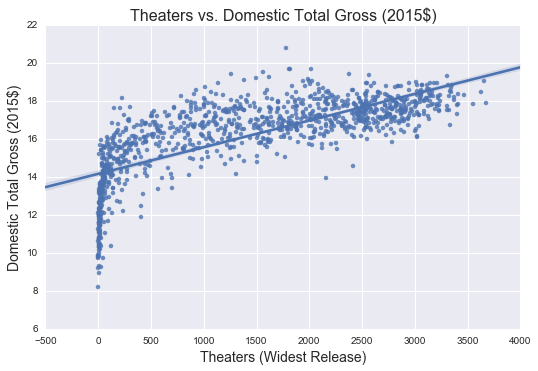

In [102]:
sns.lmplot('theaters', 'dadj_gross_log', newer_movies, size=5, aspect=1.5)
plt.title('Theaters vs. Domestic Total Gross (2015$)', fontsize=16)
plt.xlabel('Theaters (Widest Release)', fontsize=14)
plt.ylabel('Domestic Total Gross (2015$)', fontsize=14)
plt.savefig('presentation/lmplot-theaters.png')
plt.show()

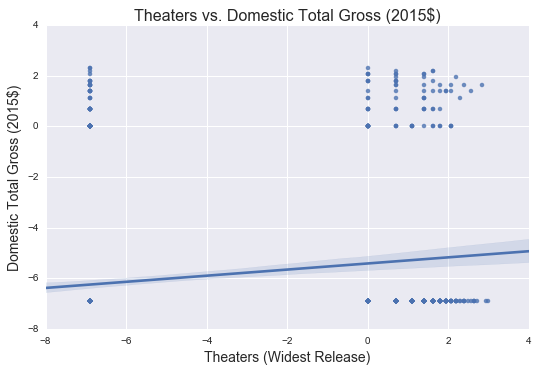

In [108]:
sns.lmplot('actor_noms_log', 'oscar_noms_log', newer_movies, size=5, aspect=1.5)
plt.title('Theaters vs. Domestic Total Gross (2015$)', fontsize=16)
plt.xlabel('Theaters (Widest Release)', fontsize=14)
plt.ylabel('Domestic Total Gross (2015$)', fontsize=14)
#plt.savefig('presentation/lmplot-theaters.png')
plt.show()

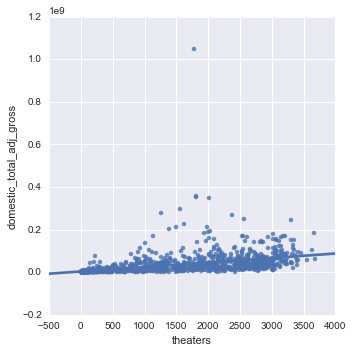

In [88]:
sns.lmplot('theaters', 'domestic_total_adj_gross', newer_movies)
plt.show()

Budget vs. domestic total gross.

In [2289]:
# plot dom total adj gross vs features 
features = ['dom_roi_log', 'dom_roi', 'domestic_total_adj_gross', 'clean_rating', 
            'theaters', 'theaters2', 'new_genre', 'runtime_mins', 'season', 'oscar_noms', 'oscar_noms_log']

# scatter_matrix(train[features], figsize = (10, 10), alpha = 0.5, diagonal='hist')
# plt.show()

In [2290]:
# plot oscar noms vs. theaters
features = ['oscar_noms_log', 'oscar_noms', 
            'oscar_noms_sq', 'theaters3', 'dom_roi', 'runtime_mins', 'dom_roi_log']

# scatter_matrix(train[features], figsize = (10, 10), alpha = 0.5, diagonal='hist')
# plt.show()

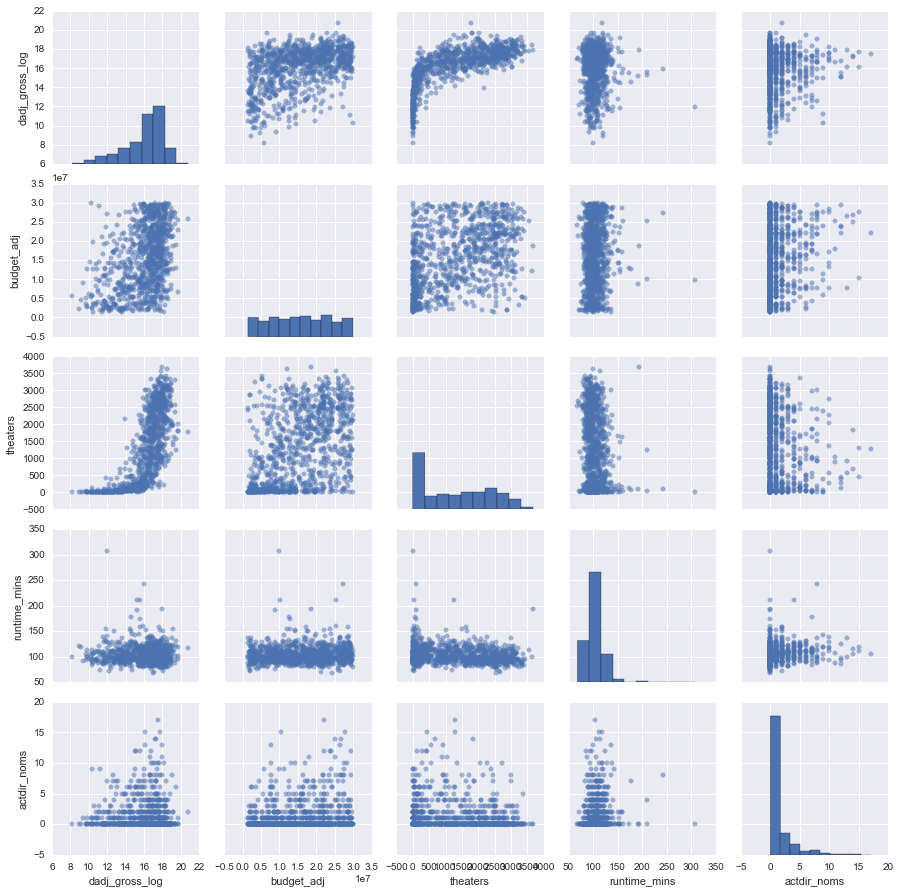

In [2495]:
features2 = ['oscar_noms_log', 'dom_roi', 'theaters', 'theaters2', 'runtime_mins']

tired = ['dadj_gross_log', 'budget_adj', \
            'theaters', 
            'runtime_mins', 
            'actdir_noms']

plot = sns.PairGrid(cvtrain[tired])
plot.map_diag(plt.hist)
plot.map_upper(plt.scatter, alpha = 0.5)
plot.map_lower(plt.scatter, alpha = 0.5);

### parse actor, director, writer, producer data...

In [ ]:
def get_critical_people(person_type, n, threshold, data):
    '''Parse people across multiple columns and returns df
    of actors and their appearances in movies if appearances
    in entire dataset > threshold.
    Args:
    n (int) -- number of columns for that person type
    threshold (int) -- cutoff for number of appearances
    data (df) -- dataframe
    '''
    cols = [person_type + str(i) for i in range(1, n+1)] # get list of columns
    dflist = []
    for col in cols:
        dflist.append(pd.DataFrame(data[col].value_counts()))
    alldf = dflist[0]
    for i in range(1, len(dflist)):
         alldf = pd.merge(alldf, dflist[i], left_index=True, right_index=True, how = 'inner')
    alldf['total'] = alldf.sum(axis=1)
    keepdf = alldf.where(alldf['total'] > threshold).dropna()
    return keepdf

In [ ]:
# only keep people above apperance threshold 
crit_actors = get_critical_people('actors', 3, 3, train)
crit_dirs = get_critical_people('director', 1, 3, train) 
crit_producers = get_critical_people('producers', 3, 3, train)
crit_writers = get_critical_people('writers', 2, 3, train)

In [1385]:
# get list of actors 
actors_list = [index for index in crit_actors.index if index != '']
dir_list = [index for index in crit_dirs.index if index != '']
prod_list = [index for index in crit_producers.index if index != '']
wri_list = [index for index in crit_writers.index if index != '']

#### get number of oscar nominations by director and actor

In [62]:
with open('pickled_data/oscars-data.pkl', 'r') as picklefile:
     oscars = pickle.load(picklefile)
        
oscars = pd.DataFrame(oscars)

# get actors
actors = oscars[oscars.category.str.contains('Act')]
actors.year = actors.year.apply(int)

# get directors 
dirs = oscars[oscars.category == 'Best Director']
dirs.year = dirs.year.apply(int)

In [63]:
def count_nominations(df, person, year):
    """Total nominations before a given year for an actor or director.
    args:
        df (dataframe): data frame
        person (string): director or actor name name
        year (int): cutoff year
    returns:
        (int) number of nominations
    """
    return df[df.person == person][df.year < year].shape[0]

### clean up features - oscars

In [64]:
# clean up oscars model a bit
'''things to clean:
- rating: R vs. not R 
- seasons: holiday, winter, other 
- genres: drama, foreign, historical + need to split other back out...'''

# ratings: split into R and not R
def split_r_rating(r):
    return r if r == 'R' else 'other'

# seasons: split into holiday, winter, and other
def recat_seasons(season):
    rm_seasons = ['spring', 'summer', 'fall']
    return 'other' if season in rm_seasons else season

# genres: split into drama, foreign, historical, war, western, other
def recat_genre(genre):
    keep_genres = ['Drama', 'Foreign', 'Historical', 'War']
    return genre if genre in keep_genres else 'other'

# log transform
def log_transform(stat):
    if stat > 0:
        return math.log(stat)
    elif stat == 0:
        return math.log(stat + .001)
    else:
        return math.log(1 + stat)

In [65]:
# add actor oscar nominations up to movie release year
newer_movies['actor_noms'] = newer_movies.apply(
    lambda row: sum(map(lambda a: count_nominations(actors, a, row.release_year), row.actors)), axis=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [66]:
# add director oscar nominations up to movie release year
newer_movies['dir_noms'] = newer_movies.apply(
    lambda row: sum(map(lambda d: count_nominations(dirs, d, row.release_year), row.director)), axis=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [70]:
clean_rating(newer_movies, split_r_rating, 'r_rating')
recat(newer_movies, recat_seasons, 'hw_season', 'season')
recat(newer_movies, recat_genre, 'recat_genre', 'new_genre')
recat(newer_movies, log_transform, 'oscar_noms_log', 'oscar_noms')
recat(newer_movies, lambda x: x**2, 'oscar_noms_sq', 'oscar_noms')
recat(newer_movies, lambda x: x**2, 'runtime_sq', 'runtime_mins')
recat(newer_movies, lambda x: x**3, 'runtime3', 'runtime_mins')
recat(newer_movies, lambda x: x**4, 'runtime4', 'runtime_mins')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
recat(newer_movies, log_transform, 'actor_noms_log', 'actor_noms')
recat(newer_movies, log_transform, 'dir_noms_log', 'dir_noms')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
newer_movies['actdir_noms'] = newer_movies.actor_noms + newer_movies.dir_noms
newer_movies['actxdir_noms'] = newer_movies.actor_noms * newer_movies.dir_noms
recat(newer_movies, log_transform, 'actdir_noms_log', 'actdir_noms')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

### clean up features - roi

In [73]:
'''Notes:
- theaters have significant correlation, but colinear?
- oscar noms predictive but colinear?
- rating - signficant for everything except nc-17
- genre - significant for horror; maybe romance? keep horror, act_adven, romance, then others

not predictive:
- season
- runtime'''

'''Plot scatter matrix between all variables?'''

def roi_rating(rating):
    rm_rating = ['', 'NC-17']
    return 'other' if rating in rm_rating else rating

def roi_genres(genre):
    keep_genres = ['Horror', 'Drama', 'Foreign', 'Family']
    return genre if genre in keep_genres else 'other'

# recat lead actor, dir, etc. - can probably simply to one function but need to figure out how to call
# args when implementing these functions in recat()
def crit_actor(person):
    return person if person in actors_list else 'other'

def crit_dir(person):
    return person if person in dir_list else 'other'

def crit_prod(person):
    return person if person in prod_list else 'other'

def crit_wri(person):
    return person if person in wri_list else 'other'
    
    
# actors_list = [index for index in crit_actors.index if index != '']
# dir_list = [index for index in crit_dirs.index if index != '']
# prod_list = [index for index in crit_producers.index if index != '']
# wri_list = [index for index in crit_writers.index if index != '']

In [74]:
recat(newer_movies, roi_rating, 'roi_rating', 'clean_rating')
recat(newer_movies, roi_genres, 'roi_genre', 'new_genre')
recat(newer_movies, log_transform, 'theaters_log', 'theaters')
recat(newer_movies, log_transform, 'dom_roi_log', 'dom_roi')
recat(newer_movies, lambda x: x**2, 'theaters2', 'theaters')
recat(newer_movies, lambda x: x**3, 'theaters3', 'theaters')
recat(newer_movies, lambda x: x**4, 'theaters4', 'theaters')
recat(newer_movies, lambda x: x**5, 'theaters5', 'theaters')
recat(newer_movies, lambda x: x**6, 'theaters6', 'theaters')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
recat(newer_movies, crit_actor, 'crit_actor1', 'actors1')
recat(newer_movies, crit_dir, 'crit_dir1', 'director1')
recat(newer_movies, crit_prod, 'crit_prod1', 'producers1')
recat(newer_movies, crit_wri, 'crit_wri1', 'writers1')

NameError: global name 'actors_list' is not defined

In [76]:
recat(newer_movies, log_transform, 'dadj_gross_log', 'domestic_total_adj_gross')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### interaction effects

### cross-validation set up

In [77]:
# assumptions
trainyr_max = 2009.0
trainandcv_max = 2012.0
cvyr = [2010.0, 2011.0, 2012.0]
testyr = [2013.0, 2014.0, 2015.0]

In [78]:
# update keep list with values so that they are included in training and test set 
keep = ['release_year', 'budget', 'budget_adj', 'oscar_noms', 'oscar_noms_sq', 'oscar_noms_log', 'runtime_mins', 
        'theaters', 'r_rating', 'hw_season', 'recat_genre', 'theaters_log', 'runtime_sq', 'runtime3', 'runtime4',
        'theaters2', 'theaters3', 'theaters4', 'dom_roi', 'dom_roi_log', 'actor_noms', 'dir_noms', 'actor_noms_log',
       'dir_noms_log', 'actxdir_noms', 'actdir_noms_log', 'actdir_noms', 'domestic_total_adj_gross',
        'dadj_gross_log', 'roi_genre', 'roi_rating']

In [79]:
# get dummies and drop "other" dummies
# rerun this if keep list is updated 
temp = newer_movies[keep]
temp.dropna(inplace = True)
dummies = pd.get_dummies(temp)
# keep_dummy = [c for c in dummies.columns if 'other' not in c.lower()]
# formodel = dummies[keep_dummy]
formodel = sm.add_constant(dummies)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2245]:
# testing interaction effects - rating x genre 
formodel['horror_R'] = formodel.roi_rating_R * formodel.roi_genre_Horror

In [1891]:
#pd.isnull(temp).any().nonzero()[0]

array([], dtype=int64)

In [80]:
formodel.shape

(1103, 47)

In [84]:
train.shape

(743, 47)

In [83]:
cvtrain.shape

(961, 47)

In [82]:
# split into train, val, test
train = formodel[formodel['release_year'] <= trainyr_max]
cvtrain = formodel[formodel['release_year'] <= trainandcv_max]
val = formodel[formodel['release_year'].isin(cvyr)]
test = formodel[formodel['release_year'].isin(testyr)]

In [85]:
# check if they add up
print train.shape[0] + val.shape[0] + test.shape[0] == formodel.shape[0]
print train.shape[0], val.shape[0], test.shape[0] 

# check percentages
print 'train as % of total: ', float(train.shape[0]) / float(formodel.shape[0])
print 'cv as % of total: ', float(val.shape[0]) / float(formodel.shape[0])
print 'test as % of total: ', float(test.shape[0]) / float(formodel.shape[0])

True
743 218 142
train as % of total:  0.673617407072
cv as % of total:  0.197642792384
test as % of total:  0.128739800544


In [1585]:
# # get model using skl
# def format_df(features, ind, data):
#     '''Format df for use in skl linear regression.
#     Args:
#     cat_features (list) -- list of column names of categorical features
#     cont_features (list) -- list of column names of continuous features
#     ind (str) - name of dependent var to predict
#     data (df) - dataset to use
#     '''
#     vals = features + [ind] + ['release_year'] # get list of all columns being used in model
#     data.dropna(subset = vals, inplace = True) # drop rows with NaN in any column 
#     dummies = pd.get_dummies(data[vals])
#     # need to drop one dummy for each cat -- automatically drops anything with "other" 
#     keep_dummy = [c for c in dummies.columns if 'other' not in c.lower()] 
#     dummies = dummies[keep_dummy] # full df with dummy variables
    
#     # split data for train, val, test
#     train = dummies[dummies['release_year'] <= trainyr_max]
#     val = dummies[dummies['release_year'].isin(cvyr)]
#     test = dummies[dummies['release_year'].isin(testyr)]
#     return train, val, test 

# def get_Xy(features, ind, data):
#     X = data[features]
#     y = data[ind]
#     return X, y

In [ ]:
# # some more checks
# train.groupby('release_year').count()
# cv.groupby('release_year').count()
# test.groupby('release_year').count()

### set up functions for regression

In [2004]:
# get model using skl
def get_xy_old(features, ind, df):
    """Get X and y for use in skl linear regression.
    """
    # match general feature category to all its dummies
    all_features = ['const']
    cols = list(df.columns)
    for feature in features:
        all_features.extend([col for col in cols if feature in col])
    # get df with dummies for features
    X = df[all_features]
    y = df[ind]
    return X, y

def get_xy(features, ind, df):
    """Get X and y for use in skl linear regression.
    """
    X = df[features]
    y = df[ind]
    return X, y

In [2193]:
def regress_skl(X, y):  
    '''Fit linear regression model using skl.
    Prints rsq and intercept and returns model.'''
    # fit model
    m = LinearRegression()
    m.fit(X, y)
    coefs = zip(X.columns, m.coef_)
    rsq = m.score(X, y)
    intercept = m.intercept_
    print 'rsquared: ', rsq
    print 'intercept: ', intercept
#     print 'coefs: ', coefs
    return m

def reg_lasso(X, y, alpha):  
    '''Fit linear regression model using l1 regularization.'''
    # fit model
    m = linear_model.Lasso(alpha=alpha)
    m.fit(X, y)
    coefs = zip(X.columns, m.coef_)
    rsq = m.score(X, y)
    intercept = m.intercept_
    print 'rsquared: ', rsq
    print 'intercept: ', intercept
#     print 'coefs: ', coefs
    return m

def validate(model, X_val, y_val, X, y):
    '''Generate predicted values for validation set and compute mean squared
    error vs. training set.
    Returns for the validation set: residuals, mse, ypred values. 
    Args:
    model -- fitted linear regression model to use for predictions
    X, y -- X, y of training set
    X_val, y_val = X, y of validation set 
    '''
    val_ypred = model.predict(X_val)
    val_resid = y_val - val_ypred
    val_mse = mean_squared_error(y_val, val_ypred)
    
    train_ypred = model.predict(X)
    train_resid = y - train_ypred
    train_mse = mean_squared_error(y, train_ypred)
    print 'train mse: ', train_mse, 'vs. val mse: ', val_mse
    return val_resid, val_mse, val_ypred

def plot_qq(resid):
    stats.probplot(resid, dist="norm", plot=plt)
    plt.show()

def cross_validate_mse(X, y, folds):
    '''Cross validate model. Returns mean mse.'''
    scores = cross_validation.cross_val_score(LinearRegression(), X, y, scoring='mean_squared_error', cv=folds)
    return scores.mean()

def cross_validate(X, y, folds):
    '''Cross validate model. Returns mean r-squared.'''
    scores = cross_validation.cross_val_score(LinearRegression(), X, y, cv=folds)
    return scores.mean()
    
#     sse = sum((y_val - y_pred)**2)
#     mse = sse / len(y_val)

### predict dom roi

In [ ]:
'''Notes:
- theaters have significant correlation, but colinear?
- oscar noms predictive but colinear?
- rating - signficant for everything except nc-17
- genre - significant for horror; maybe romance? keep horror, act_adven, romance, then others

not predictive:
- season
- runtime'''

'''Plot scatter matrix between all variables?'''

#### model 1. everything! genre, theaters, rating, oscars

In [1289]:
roi1 = smf.ols(formula="dom_roi ~ new_genre + theaters + clean_rating + \
                        oscar_noms + director1 + actors1 + writers1 + producers1", 
                  data = train).fit()
roi1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dom_roi   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2.798
Date:                Wed, 27 Jan 2016   Prob (F-statistic):           4.87e-07
Time:                        10:34:57   Log-Likelihood:                -750.50
No. Observations:                 711   AIC:                             2789.
Df Residuals:                      67   BIC:                             5730.
Df Model:                         643                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -0.0241      1.873     -0.013      0.990        -3.763     3.715
new_genre[T.Animation]                                     -2.0312      1.932     -1.051      0.297        -5.888     1.826
new_genre[T.Comedy]                                        -0.1487      1.726     -0.086      0.932        -3.595     3.297
new_genre[T.Crime_Thriller]                                -0.6298      1.909     -0.330      0.743        -4.440     3.181
new_genre[T.Documentary]                                   -2.5656      3.716     -0.691      0.492        -9.982     4.851
new_genre[T.Drama]                                         -0.4738      1.656     -0.286      0.776        -3.779     2.831
new_genre[T.Family]                                         0.0456      2.073      0.022      0.983        -4.092     4.183
new_genre[T.Fantasy_Scifi]                                  0.3798      1.866      0.204      0.839        -3.345     4.104
new_genre[T.Foreign]                                       -0.6399      1.676     -0.382      0.704        -3.986     2.706
new_genre[T.Historical]                                     0.1355      1.611      0.084      0.933        -3.080     3.351
new_genre[T.Horror]                                        -1.0784      1.686     -0.640      0.525        -4.444     2.287
new_genre[T.Musical]                                       -1.5898      2.364     -0.672      0.504        -6.309     3.129
new_genre[T.None]                                          -0.5120      1.742     -0.294      0.770        -3.989     2.965
new_genre[T.Other]                                          2.0214      1.374      1.471      0.146        -0.722     4.764
new_genre[T.Romance]                                       -0.4918      1.647     -0.299      0.766        -3.779     2.796
new_genre[T.Sports]                                        -0.3977      2.593     -0.153      0.879        -5.573     4.778
new_genre[T.War]                                           -1.2583      1.500     -0.839      0.405        -4.253     1.736
new_genre[T.Western]                                        0.1591      1.511      0.105      0.916        -2.856     3.174
clean_rating[T.G]                                           2.0671      1.940      1.066      0.290        -1.805     5.939
clean_rating[T.NC-17]                                       1.9091      4.287      0.445      0.658        -6.649    10.467
clean_rating[T.PG]                                         -0.3961      1.381     -0.287      0.775        -3.154     2.361
clean_rating[T.PG-13]                                      -1.1793      1.370     -0.861      0.392        

In [1211]:
# validate

Index([u'director1[T.2/9/10 2010 Preview: Paranormal Activity 2]',
       u'director1[T.Alex Kendrick]', u'director1[T.D.J. Caruso]',
       u'director1[T.Daniel Stamm]', u'director1[T.Desmond Nakano]',
       u'director1[T.Drew Barrymore]', u'director1[T.Eli Roth]',
       u'director1[T.Florian Henckel von Donnersmarck]',
       u'director1[T.Garry Marshall]', u'director1[T.James Wan]',
       u'director1[T.Jeff Tremaine]', u'director1[T.Larry Charles]',
       u'director1[T.Marc Forster]', u'director1[T.Michael Moore]',
       u'director1[T.Mike Newell]', u'director1[T.Niki Caro]',
       u'director1[T.Patty Jenkins]', u'director1[T.Scott Cooper]',
       u'director1[T.Sofia Coppola]', u'director1[T.Tod Williams]',
       u'director1[T.Todd Field]', u'director1[T.Tom Hooper]',
       u'director1[T.Zach Braff]',
       u'director1[T.table.chart-wide { width: 100%; }]',
       u'actors1[T.Alan Alda]', u'actors1[T.Alan Rickman]',
       u'actors1[T.Alex Kendrick]', u'actors1[T.Amber Tam

#### model 2. 
same as model 1 but with only actors, dir, writer, and producers that appear more than 3 times

In [1401]:
train.columns

Index([u'title', u'release_date', u'closing_date', u'actors', u'budget',
       u'director', u'distributor', u'dom_total_gross',
       u'domestic_total_adj_gross', u'genre', u'intl_total_gross',
       u'oscar_noms', u'oscar_wins', u'producers', u'rating', u'runtime_mins',
       u'theaters', u'url', u'writers', u'director1', u'director2',
       u'director3', u'actors1', u'actors2', u'actors3', u'actors4',
       u'actors5', u'writers1', u'writers2', u'producers1', u'producers2',
       u'producers3', u'season', u'clean_rating', u'new_genre',
       u'release_year', u'infl_rate', u'budget_adj', u'dom_roi', u'r_rating',
       u'hw_season', u'recat_genre', u'oscar_noms_log', u'roi_rating',
       u'roi_genre', u'theaters_log', u'theaters^2', u'theaters2',
       u'theaters3', u'theaters4', u'dom_roi_log', u'crit_actor1',
       u'crit_dir1', u'crit_prod1', u'crit_wri1'],
      dtype='object')

In [1402]:
roi2 = smf.ols(formula="dom_roi ~ new_genre + theaters + clean_rating + \
                        oscar_noms + crit_dir1 + crit_actor1 + crit_wri1 + crit_prod1", 
                  data = train).fit()
roi2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dom_roi   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     2.044
Date:                Wed, 27 Jan 2016   Prob (F-statistic):           1.14e-06
Time:                        12:15:17   Log-Likelihood:                -1850.2
No. Observations:                 711   AIC:                             3864.
Df Residuals:                     629   BIC:                             4239.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------
Intercept                                -2.6710      5.686     -0.470      0.639       -13.836     8.494
new_genre[T.Animation]                   -0.8492      1.334     -0.637      0.525        -3.469     1.771
new_genre[T.Comedy]                       0.8247      0.685      1.203      0.229        -0.521     2.171
new_genre[T.Crime_Thriller]               0.3971      0.780      0.509      0.611        -1.134     1.929
new_genre[T.Documentary]                  2.1835      1.745      1.251      0.211        -1.244     5.611
new_genre[T.Drama]                        0.4273      0.765      0.559      0.577        -1.075     1.930
new_genre[T.Family]                      -0.2563      1.117     -0.229      0.819        -2.451     1.938
new_genre[T.Fantasy_Scifi]                0.2932      0.986      0.297      0.766        -1.644     2.230
new_genre[T.Foreign]                     -0.1244      1.070     -0.116      0.907        -2.225     1.976
new_genre[T.Historical]                  -0.3141      0.917     -0.343      0.732        -2.114     1.486
new_genre[T.Horror]                       1.4918      0.747      1.997      0.046         0.025     2.959
new_genre[T.Musical]                      0.7755      0.998      0.777      0.438        -1.185     2.736
new_genre[T.None]                        -0.1034      0.877     -0.118      0.906        -1.825     1.618
new_genre[T.Other]                        3.6188      2.537      1.426      0.154        -1.364     8.601
new_genre[T.Romance]                      1.3143      0.780      1.685      0.092        -0.217     2.846
new_genre[T.Sports]                       0.4222      1.092      0.387      0.699        -1.722     2.567
new_genre[T.War]                         -2.5365      1.883     -1.347      0.179        -6.235     1.162
new_genre[T.Western]                     -0.5305      1.975     -0.269      0.788        -4.408     3.347
clean_rating[T.G]                         0.8488      1.648      0.515      0.607        -2.388     4.086
clean_rating[T.NC-17]                    -0.5755      1.869     -0.308      0.758        -4.245     3.094
clean_rating[T.PG]                       -0.0499      1.152     -0.043      0.965        -2.313     2.213
clean_rating[T.PG-13]                    -0.9458      1.069     -0.885      0.377        -3.045     1.154
clean_rating[T.R]                        -0.2913      1.035     -0.281      0.778        -2.324     1.741
crit_dir1[T.Kevin Smith]                 -0.5183      2.527     -0.205      0.838        -5.481     4.444
crit_dir1[T.Mark S. Waters]               0.3547      2.566      0.138      0.890        -4.684     5.393
crit_dir1[T.Michael Moore]                2.8502      2.706      1.053      0.293        -2.464     8.164
crit_dir1

#### model 3. 
same as model 2, but with:
genre = horror, act_adven, romance, others  
rating = G/PG/PG-13/R/others  
theaters = theaters  
oscar_noms

In [1404]:
roi3 = smf.ols(formula="dom_roi ~ roi_genre + theaters + roi_rating + + crit_dir1 \
                        + crit_actor1 + crit_wri1 + crit_prod1 + oscar_noms", 
                  data = train).fit()
roi3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dom_roi   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     2.307
Date:                Wed, 27 Jan 2016   Prob (F-statistic):           1.19e-07
Time:                        12:18:47   Log-Likelihood:                -1857.8
No. Observations:                 711   AIC:                             3850.
Df Residuals:                     644   BIC:                             4156.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------
Intercept                                -3.1317      5.671     -0.552      0.581       -14.268     8.005
roi_genre[T.Documentary]                  2.3256      1.712      1.359      0.175        -1.036     5.687
roi_genre[T.Horror]                       1.4569      0.744      1.957      0.051        -0.005     2.919
roi_genre[T.other]                        0.6590      0.647      1.018      0.309        -0.612     1.930
roi_rating[T.PG]                         -0.2083      1.129     -0.184      0.854        -2.426     2.009
roi_rating[T.PG-13]                      -0.6952      1.086     -0.640      0.522        -2.828     1.437
roi_rating[T.R]                          -0.0789      1.089     -0.072      0.942        -2.217     2.059
roi_rating[T.other]                      -0.2579      1.380     -0.187      0.852        -2.967     2.451
crit_dir1[T.Kevin Smith]                 -0.4783      2.500     -0.191      0.848        -5.387     4.431
crit_dir1[T.Mark S. Waters]               0.6046      2.529      0.239      0.811        -4.361     5.570
crit_dir1[T.Michael Moore]                2.8525      2.657      1.074      0.283        -2.364     8.069
crit_dir1[T.Mira Nair]                    0.2409      3.009      0.080      0.936        -5.668     6.150
crit_dir1[T.Steven Soderbergh]           -0.4847      2.471     -0.196      0.845        -5.338     4.368
crit_dir1[T.Woody Allen]                 -0.6256      2.461     -0.254      0.799        -5.458     4.207
crit_dir1[T.other]                        0.0351      1.757      0.020      0.984        -3.415     3.485
crit_actor1[T.Alfred Molina]              0.0997      3.892      0.026      0.980        -7.543     7.742
crit_actor1[T.Anna Faris]                -0.9379      2.608     -0.360      0.719        -6.059     4.183
crit_actor1[T.Bill Murray]                2.5821      3.021      0.855      0.393        -3.350     8.514
crit_actor1[T.Chris Cooper]               0.2199      3.076      0.071      0.943        -5.820     6.260
crit_actor1[T.Christina Ricci]           -1.3722      3.880     -0.354      0.724        -8.991     6.247
crit_actor1[T.Courteney Cox]             -0.5516      3.013     -0.183      0.855        -6.469     5.366
crit_actor1[T.Danny DeVito]              -1.2944      3.880     -0.334      0.739        -8.914     6.325
crit_actor1[T.Drew Barrymore]            -2.2124      3.883     -0.570      0.569        -9.837     5.412
crit_actor1[T.Eva Mendes]                -2.8193      3.904     -0.722      0.470       -10.485     4.846
crit_actor1[T.Greg Kinnear]               2.7675      3.900      0.710      0.478        -4.890    10.425
crit_actor1[T.Holly Hunter]               0.1202      4.602      0.026      0.979        -8.916     9.156
crit_acto

In [1427]:
# validate
ind = 'dom_roi'
cont_features = ['theaters', 'oscar_noms']
cat_features = ['roi_genre', 'roi_rating', 'crit_actor1']

X, y = format_skl(cat_features, cont_features, ind, train)
Xval, yval = format_skl(cat_features, cont_features, ind, val)

roi3 = regress_skl(X, y)
validate(roi3, Xval, yval)

rsquared:  0.183333858509
intercept:  -0.806796075706


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: shapes (222,17) and (41,) not aligned: 17 (dim 1) != 41 (dim 0)

### model 4. 
rm people

In [1425]:
roi4 = smf.ols(formula="dom_roi ~ roi_genre + roi_rating + theaters + oscar_noms", 
                  data = train).fit()
roi4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dom_roi   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     16.01
Date:                Wed, 27 Jan 2016   Prob (F-statistic):           5.26e-24
Time:                        12:30:26   Log-Likelihood:                -1866.8
No. Observations:                 711   AIC:                             3754.
Df Residuals:                     701   BIC:                             3799.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -1.0286      1.252     -0.821      0.412        -3.487     1.430
roi_genre[T.Documentary]     3.7634      1.334      2.822      0.005         1.145     6.382
roi_genre[T.Horror]          1.3513      0.705      1.918      0.056        -0.032     2.735
roi_genre[T.other]           0.6145      0.613      1.002      0.317        -0.589     1.818
roi_rating[T.PG]            -0.1340      1.091     -0.123      0.902        -2.277     2.009
roi_rating[T.PG-13]         -0.7943      1.050     -0.756      0.450        -2.856     1.268
roi_rating[T.R]             -0.1908      1.051     -0.182      0.856        -2.254     1.872
roi_rating[T.other]         -0.3913      1.332     -0.294      0.769        -3.006     2.224
theaters                     0.0012      0.000      8.197      0.000         0.001     0.001
oscar_noms                   0.6058      0.095      6.372      0.000         0.419     0.792
==============================================================================
Omnibus:                      989.474   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           218677.700
Skew:                           7.414   Prob(JB):                         0.00
Kurtosis:                      87.627   Cond. No.                     3.17e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1446]:
# validate
ind = 'dom_roi_log'
cont_features = ['theaters', 'oscar_noms']
cat_features = ['roi_genre', 'roi_rating']

X, y = format_skl(cat_features, cont_features, ind, train)
Xval, yval = format_skl(cat_features, cont_features, ind, val)

roi4 = regress_skl(X, y)
roi4_resid, roi4_mse, roi4_ypred = validate(roi4, Xval, yval)
print roi4_mse

rsquared:  0.187513293952
intercept:  -1.07249315875
1.33759557316


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


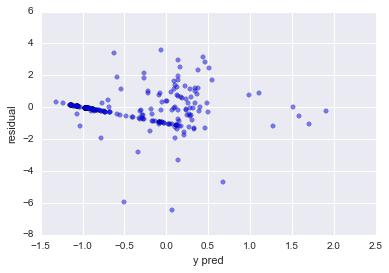

In [1451]:
# plot predicted values vs. residuals
plt.scatter(roi4_ypred, roi4_resid, alpha = 0.5)
plt.xlabel('y pred')
plt.ylabel('residual')
plt.show()

### model 5
use domestic roi log

In [1462]:
roi5 = smf.ols(formula="dom_roi_log ~ new_genre", 
                  data = train).fit()
roi5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            dom_roi_log   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.941
Date:                Wed, 27 Jan 2016   Prob (F-statistic):           6.49e-05
Time:                        12:53:58   Log-Likelihood:                -1114.6
No. Observations:                 711   AIC:                             2265.
Df Residuals:                     693   BIC:                             2347.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.4680      0.205     -2.287      0.022        -0.870    -0.066
new_genre[T.Animation]         -0.0658      0.375     -0.176      0.861        -0.802     0.670
new_genre[T.Comedy]             0.1883      0.224      0.840      0.401        -0.252     0.629
new_genre[T.Crime_Thriller]     0.1594      0.253      0.629      0.529        -0.338     0.657
new_genre[T.Documentary]        0.9990      0.463      2.157      0.031         0.090     1.908
new_genre[T.Drama]             -0.0017      0.239     -0.007      0.994        -0.471     0.467
new_genre[T.Family]             0.6333      0.315      2.009      0.045         0.014     1.252
new_genre[T.Fantasy_Scifi]      0.0466      0.319      0.146      0.884        -0.580     0.673
new_genre[T.Foreign]           -0.2283      0.333     -0.686      0.493        -0.882     0.426
new_genre[T.Historical]        -0.3780      0.281     -1.343      0.180        -0.931     0.174
new_genre[T.Horror]             0.4786      0.244      1.965      0.050         0.000     0.957
new_genre[T.Musical]            0.4237      0.328      1.292      0.197        -0.220     1.068
new_genre[T.None]              -0.5320      0.267     -1.993      0.047        -1.056    -0.008
new_genre[T.Other]              1.6413      0.856      1.918      0.056        -0.039     3.322
new_genre[T.Romance]            0.1082      0.253      0.427      0.669        -0.389     0.605
new_genre[T.Sports]             0.3283      0.358      0.917      0.359        -0.375     1.031
new_genre[T.War]               -0.7835      0.622     -1.259      0.208        -2.005     0.438
new_genre[T.Western]           -0.3951      0.622     -0.635      0.526        -1.617     0.827
==============================================================================
Omnibus:                       28.036   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.035
Skew:                           0.171   Prob(JB):                     1.24e-14
Kurtosis:                       4.430   Cond. No.                         23.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1432]:
# validate
ind = 'dom_roi_log'
cont_features = ['theaters2', 'oscar_noms']
cat_features = ['roi_genre', 'roi_rating']

X, y = format_skl(cat_features, cont_features, ind, train)
Xval, yval = format_skl(cat_features, cont_features, ind, val)

roi5 = regress_skl(X, y)
validate(roi5, Xval, yval)

rsquared:  0.155510291525
intercept:  -0.755882826901


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


19.668641066227149

### test dom total gross models

In [1]:
sns.lmplot('theaters', 'dadj_gross_log', cvtrain)

NameError: name 'sns' is not defined

In [2186]:
cvtrain.columns

Index([u'const', u'release_year', u'budget', u'budget_adj', u'oscar_noms',
       u'oscar_noms_sq', u'oscar_noms_log', u'runtime_mins', u'theaters',
       u'theaters_log', u'runtime_sq', u'runtime3', u'runtime4', u'theaters2',
       u'theaters3', u'theaters4', u'dom_roi', u'dom_roi_log', u'actor_noms',
       u'dir_noms', u'actor_noms_log', u'dir_noms_log', u'actxdir_noms',
       u'actdir_noms_log', u'actdir_noms', u'domestic_total_adj_gross',
       u'dadj_gross_log', u'r_rating_R', u'r_rating_other',
       u'hw_season_holiday', u'hw_season_other', u'hw_season_winter',
       u'recat_genre_Drama', u'recat_genre_Foreign', u'recat_genre_Historical',
       u'recat_genre_War', u'recat_genre_other', u'roi_genre_Act_Adven',
       u'roi_genre_Documentary', u'roi_genre_Horror', u'roi_genre_other'],
      dtype='object')

In [2426]:
def get_rsq4plot(features, ind, df):
    """Gets list of adjusted rsquares based on number
    of features included.
    Args:
    features (list) -- list of features
    ind (str) -- column name of independent var
    df (df) -- df
    Returns:
    list of (num features, adjusted r squared tuples)
    """
    adj_rsqs = []
    feats = []
    for i in range(1, len(features)):
        feats.append(features[:i+1])
    for feat in feats:
        X, y = get_xy(feat, ind, df)
        model = sm.OLS(y, X)
        model = model.fit()
        adj_rsqs.append(model.rsquared_adj)
    print feats
    return (map(lambda x: len(x), feats), adj_rsqs)  

def get_mse4plot(features, ind, df):
    """Gets list of average mse from crossvalidation based on number
    of features included.
    Args:
    features (list) -- list of features
    ind (str) -- column name of independent var
    df (df) -- df
    Returns:
    list of (num features, average mse tuples); note that 
    first pair is for the intercept only 
    """
    avg_mse = []
    feats = []
    for i in range(1, len(features)):
        feats.append(features[:i+1])
    for feat in feats:
        X, y = get_xy(feat, ind, df)
        avg_mse.append(cross_validate_mse(X, y, 5))
    return (map(lambda x: len(x), feats), map(lambda x: abs(x), avg_mse))    

In [2481]:
features_gross = ['const', 
            'budget_adj', \
            'theaters', 
            'runtime_mins', 
            'actdir_noms', 
            'hw_season_holiday',
            'roi_genre_Horror', 
            'roi_rating_G', 'roi_rating_PG', 'roi_rating_PG-13', 'roi_rating_R']
            
# 'actxdir_noms', 'actdir_noms_log', 'actdir_noms'
            
ind = 'dadj_gross_log'
X, y = get_xy(features_gross, ind, cvtrain)
gross = sm.OLS(y, X)
gross = gross.fit()
gross.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         dadj_gross_log   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     134.3
Date:                Thu, 28 Jan 2016   Prob (F-statistic):          4.44e-174
Time:                        23:19:16   Log-Likelihood:                -1660.4
No. Observations:                 961   AIC:                             3343.
Df Residuals:                     950   BIC:                             3396.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                11.5008      0.407     28.264      0.000        10.702    12.299
budget_adj         1.497e-08   6.42e-09      2.333      0.020      2.38e-09  2.76e-08
theaters              0.0015    5.3e-05     27.847      0.000         0.001     0.002
runtime_mins          0.0121      0.003      4.455      0.000         0.007     0.017
actdir_noms           0.0385      0.019      2.003      0.045         0.001     0.076
hw_season_holiday     0.6086      0.126      4.811      0.000         0.360     0.857
roi_genre_Horror     -0.3367      0.156     -2.155      0.031        -0.643    -0.030
roi_rating_G          0.9712      0.439      2.210      0.027         0.109     1.833
roi_rating_PG         0.8569      0.294      2.919      0.004         0.281     1.433
roi_rating_PG-13      1.0166      0.271      3.748      0.000         0.484     1.549
roi_rating_R          1.1495      0.258      4.454      0.000         0.643     1.656
==============================================================================
Omnibus:                       56.736   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.731
Skew:                          -0.472   Prob(JB):                     1.47e-19
Kurtosis:                       4.129   Cond. No.                     2.57e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [2430]:
numfeat_gross, mses_gross = get_mse4plot(features_gross, 'dadj_gross_log', cvtrain)
numfeat_gross2, rsqs_gross = get_rsq4plot(features_gross, 'dadj_gross_log', cvtrain)

[['const', 'budget_adj'], ['const', 'budget_adj', 'theaters'], ['const', 'budget_adj', 'theaters', 'runtime_mins'], ['const', 'budget_adj', 'theaters', 'runtime_mins', 'actdir_noms'], ['const', 'budget_adj', 'theaters', 'runtime_mins', 'actdir_noms', 'hw_season_holiday'], ['const', 'budget_adj', 'theaters', 'runtime_mins', 'actdir_noms', 'hw_season_holiday', 'roi_genre_Horror'], ['const', 'budget_adj', 'theaters', 'runtime_mins', 'actdir_noms', 'hw_season_holiday', 'roi_genre_Horror', 'roi_rating_G'], ['const', 'budget_adj', 'theaters', 'runtime_mins', 'actdir_noms', 'hw_season_holiday', 'roi_genre_Horror', 'roi_rating_G', 'roi_rating_PG'], ['const', 'budget_adj', 'theaters', 'runtime_mins', 'actdir_noms', 'hw_season_holiday', 'roi_genre_Horror', 'roi_rating_G', 'roi_rating_PG', 'roi_rating_PG-13'], ['const', 'budget_adj', 'theaters', 'runtime_mins', 'actdir_noms', 'hw_season_holiday', 'roi_genre_Horror', 'roi_rating_G', 'roi_rating_PG', 'roi_rating_PG-13', 'roi_rating_R']]


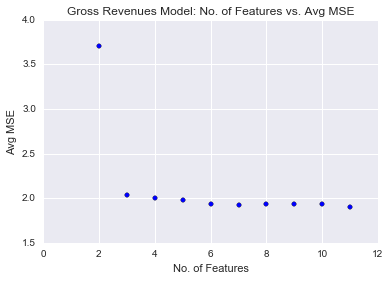

In [2431]:
# plot mse vs. num features
plt.scatter(numfeat_gross, mses_gross)
plt.title('Gross Revenues Model: No. of Features vs. Avg MSE')
plt.xlabel('No. of Features')
plt.ylabel('Avg MSE')
plt.show()

In [2455]:
print rsqs_gross

[0.17773005002081577, 0.5469171572601863, 0.55676026442136417, 0.56093319532364005, 0.57180508724760659, 0.57298509574919976, 0.5725744822097556, 0.57309052938802452, 0.57301571639325866, 0.58131045895918509]


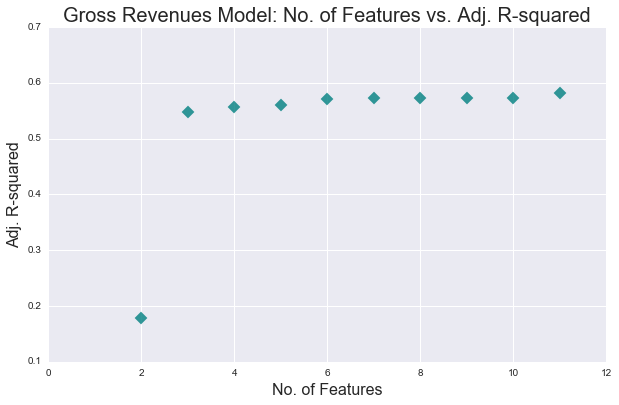

In [2454]:
# plot rsq vs. num features
plt.figure(figsize=(10, 6))
plt.scatter(numfeat2, rsqs_gross, s=75, color='teal', marker='D', alpha=0.8)
plt.title('Gross Revenues Model: No. of Features vs. Adj. R-squared', fontsize=20)
plt.xlabel('No. of Features', fontsize=16)
plt.ylabel('Adj. R-squared', fontsize=16)
plt.savefig('presentation/gross-plot.png')
plt.show()

In [2482]:
resid, mse, ypred = validate(gross, X, y, X, y)

train mse:  1.85480725064 vs. val mse:  1.85480725064


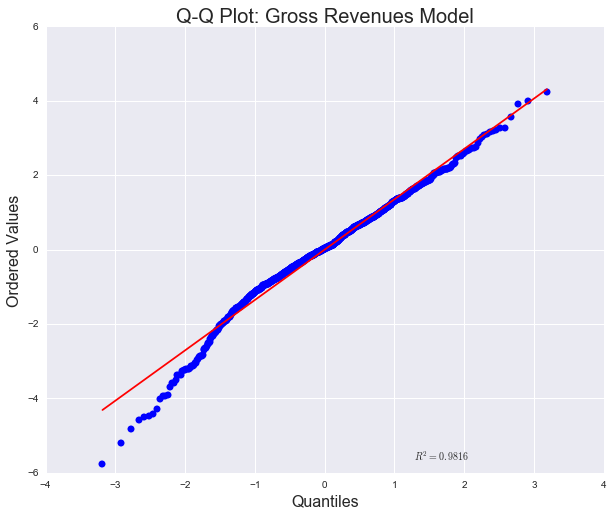

In [2490]:
plt.figure(figsize=(10, 8))
stats.probplot(resid, dist="norm", plot=plt)
plt.title('Q-Q Plot: Gross Revenues Model', fontsize=20)
plt.xlabel('Quantiles', fontsize=16)
plt.ylabel('Ordered Values', fontsize=16)
plt.savefig('presentation/qq-gross.png')
plt.show()

### investigate oscar nominations

In [1004]:
# original
oscars = smf.ols(formula="oscar_noms ~ new_genre + rating + season + theaters + runtime_mins", data = train).fit()
oscars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             oscar_noms   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     7.616
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           1.30e-26
Time:                        16:08:31   Log-Likelihood:                -1414.4
No. Observations:                 884   AIC:                             2887.
Df Residuals:                     855   BIC:                             3025.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -1.6605      0.519     -3.202      0.001        -2.678    -0.642
new_genre[T.Animation]          0.6488      0.392      1.653      0.099        -0.121     1.419
new_genre[T.Comedy]             0.1982      0.201      0.984      0.325        -0.197     0.594
new_genre[T.Crime_Thriller]     0.3077      0.233      1.321      0.187        -0.150     0.765
new_genre[T.Documentary]        0.3929      0.402      0.978      0.328        -0.396     1.182
new_genre[T.Drama]              0.7562      0.217      3.491      0.001         0.331     1.181
new_genre[T.Family]             0.3594      0.340      1.058      0.290        -0.307     1.026
new_genre[T.Fantasy_Scifi]      0.2031      0.302      0.672      0.502        -0.390     0.796
new_genre[T.Foreign]            1.0944      0.317      3.457      0.001         0.473     1.716
new_genre[T.Historical]         0.9917      0.272      3.649      0.000         0.458     1.525
new_genre[T.Horror]            -0.1448      0.222     -0.651      0.515        -0.581     0.292
new_genre[T.Musical]            0.2071      0.319      0.650      0.516        -0.418     0.832
new_genre[T.None]               0.2081      0.268      0.776      0.438        -0.318     0.734
new_genre[T.Other]              0.0253      0.734      0.034      0.972        -1.415     1.466
new_genre[T.Romance]            0.2582      0.232      1.114      0.266        -0.197     0.713
new_genre[T.Sports]             0.5579      0.341      1.638      0.102        -0.111     1.226
new_genre[T.War]                2.8364      0.641      4.423      0.000         1.578     4.095
new_genre[T.Western]            1.1259      0.580      1.943      0.052        -0.012     2.263
rating[T.NC-17]                -0.1300      0.675     -0.193      0.847        -1.455     1.195
rating[T.PG]                    0.2060      0.378      0.546      0.586        -0.535     0.947
rating[T.PG-13]                 0.4195      0.381      1.101      0.271        -0.328     1.167
rating[T.R]                     0.7007      0.382      1.833      0.067        -0.049     1.451
rating[T.Unrated]              -0.0988      0.465     -0.213      0.832        -1.011     0.814
season[T.holiday]               0.7236      0.137      5.301      0.000         0.456     0.992
season[T.spring]               -0.2579      0.127     -2.033      0.042        -0.507    -0.009
season[T.summer]               -0.0701      0.117     -0.597      0.551        -0.300     0.160
season[T.winter]               -0.2557      0.139     -1.842      0.066        -0.528     0.017
theaters                        0.0001   4.91e-05      3.009      0.003      5.14e-05     0.000
runtime_mins                    0.0093      0.003      3.431      0.001         0.004     0.015
===========

In [1009]:
# 2. optmized 
oscars_o = smf.ols(formula="oscar_noms ~ r_rating + hw_season + theaters + runtime_mins", 
                 data = train).fit()
oscars_o.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             oscar_noms   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     27.45
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           7.21e-26
Time:                        16:12:35   Log-Likelihood:                -1448.6
No. Observations:                 884   AIC:                             2909.
Df Residuals:                     878   BIC:                             2938.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -0.2698      0.303     -0.892      0.373        -0.864     0.324
r_rating[T.other]      -0.2834      0.086     -3.281      0.001        -0.453    -0.114
hw_season[T.other]     -0.9353      0.120     -7.794      0.000        -1.171    -0.700
hw_season[T.winter]    -1.1405      0.157     -7.280      0.000        -1.448    -0.833
theaters             5.833e-05   4.15e-05      1.404      0.161     -2.32e-05     0.000
runtime_mins            0.0148      0.002      6.026      0.000         0.010     0.020
==============================================================================
Omnibus:                      726.795   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14032.842
Skew:                           3.757   Prob(JB):                         0.00
Kurtosis:                      21.015   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1557]:
# test individual features 
oscars_log = smf.ols(formula = "oscar_noms_log ~ recat_genre", data = train).fit()
oscars_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         oscar_noms_log   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     26.12
Date:                Wed, 27 Jan 2016   Prob (F-statistic):           3.12e-20
Time:                        14:54:06   Log-Likelihood:                -1983.8
No. Observations:                 719   AIC:                             3978.
Df Residuals:                     714   BIC:                             4000.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    -7.8438      0.400    -19.629      0.000        -8.628    -7.059
recat_genre[T.Foreign]        1.8753      0.946      1.983      0.048         0.019     3.732
recat_genre[T.Historical]     1.0815      0.746      1.450      0.148        -0.383     2.546
recat_genre[T.War]            2.9832      1.958      1.524      0.128        -0.860     6.827
recat_genre[T.other]         -2.8706      0.431     -6.663      0.000        -3.717    -2.025
==============================================================================
Omnibus:                      265.560   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.325
Skew:                           1.913   Prob(JB):                    3.15e-158
Kurtosis:                       6.093   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1923]:
# 3. with log oscar_noms and theaters
features = ['r_rating', 'recat_genre', 'hw_season', 'theaters3', 'runtime_mins', 'dom_roi_log']
ind = 'oscar_noms_log'
X, y = get_xy(features, ind, train)
oscars3 = sm.OLS(y, X)
oscars3 = oscars3.fit()
oscars3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         oscar_noms_log   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     30.91
Date:                Wed, 27 Jan 2016   Prob (F-statistic):           1.57e-49
Time:                        23:46:49   Log-Likelihood:                -1551.7
No. Observations:                 709   AIC:                             3125.
Df Residuals:                     698   BIC:                             3176.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                     -7.6481      0.589    -12.983      0.000        -8.805    -6.492
r_rating_R                 0.7205      0.172      4.178      0.000         0.382     1.059
recat_genre_Drama          1.2294      0.260      4.726      0.000         0.719     1.740
recat_genre_Foreign        2.0808      0.532      3.913      0.000         1.037     3.125
recat_genre_Historical     1.9961      0.398      5.014      0.000         1.215     2.778
recat_genre_War            2.7945      1.102      2.536      0.011         0.631     4.958
hw_season_holiday          1.1603      0.234      4.958      0.000         0.701     1.620
hw_season_winter          -0.4319      0.236     -1.828      0.068        -0.896     0.032
theaters3              -4.722e-11   1.08e-11     -4.359      0.000     -6.85e-11  -2.6e-11
runtime_mins               0.0144      0.006      2.569      0.010         0.003     0.025
dom_roi_log                0.4544      0.049      9.209      0.000         0.358     0.551
==============================================================================
Omnibus:                      138.895   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.511
Skew:                           1.213   Prob(JB):                     1.19e-51
Kurtosis:                       4.431   Cond. No.                     1.49e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1924]:
# validate
o3 = regress_skl(X, y)
Xval, yval = get_xy(features, ind, val)
o3_resid, o3_mse, o3_ypred = validate(o3, Xval, yval, X, y)

rsquared:  0.306916421462
intercept:  -7.64807882788
train mse:  4.66143353175 vs. val mse:  5.37124246491


In [1951]:
d = {'pred': o3_ypred, 'actual': yval}
pd.DataFrame(d)

,actual,pred
61,-6.907755,-6.389941
384,-6.907755,-5.373698
459,-6.907755,-5.542960
472,1.609438,-2.736416
580,0.000000,-3.818346
620,-6.907755,-7.731195
623,-6.907755,-7.055093
698,-6.907755,-8.759407
713,2.302585,-4.994574
768,-6.907755,-5.620850


In [1965]:
math.log(4)

1.3862943611198906

In [1960]:
math.log(10, 10)

1.0

How to interpret -- 
- -6.9 = 0 oscars. 
- log = 0 is 1 oscar
- 0.69 is 2 oscars
- 1.1 is 3 oscars
- 1.38 is 4 oscars

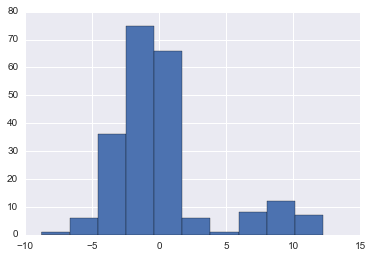

In [1744]:
plt.hist(o3_resid.values);

Residuals = yactual - ypred.

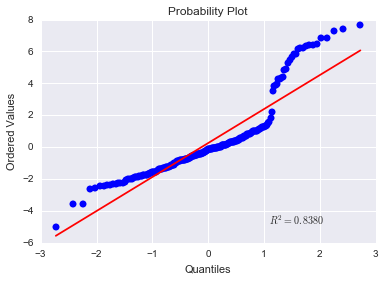

In [1925]:
plot_qq(o3_resid.values)

### model 4 - most optimized
add actors and directors nominations
director nominations log not significant -- remove?

In [2485]:
features_oscars = ['const', 
            'r_rating_R', \
            'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical', 'recat_genre_War', \
            'hw_season_holiday', \
            'theaters3', \
            'runtime_mins', 
            'dom_roi_log', 
            'actor_noms_log']

ind = 'oscar_noms_log'
X, y = get_xy(features_oscars, ind, train)
oscars4 = sm.OLS(y, X)
oscars4 = oscars4.fit()
oscars4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         oscar_noms_log   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     33.19
Date:                Thu, 28 Jan 2016   Prob (F-statistic):           2.70e-53
Time:                        23:20:04   Log-Likelihood:                -1641.4
No. Observations:                 743   AIC:                             3305.
Df Residuals:                     732   BIC:                             3356.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                     -7.3946      0.636    -11.621      0.000        -8.644    -6.145
r_rating_R                 0.6224      0.172      3.621      0.000         0.285     0.960
recat_genre_Drama          0.9900      0.267      3.708      0.000         0.466     1.514
recat_genre_Foreign        2.4173      0.540      4.479      0.000         1.358     3.477
recat_genre_Historical     1.7306      0.407      4.254      0.000         0.932     2.529
recat_genre_War            3.0766      1.009      3.050      0.002         1.096     5.057
hw_season_holiday          1.0955      0.232      4.717      0.000         0.639     1.551
theaters3              -5.074e-11   1.08e-11     -4.704      0.000     -7.19e-11 -2.96e-11
runtime_mins               0.0161      0.006      2.821      0.005         0.005     0.027
dom_roi_log                0.4995      0.049     10.099      0.000         0.402     0.597
actor_noms_log             0.0742      0.025      2.998      0.003         0.026     0.123
==============================================================================
Omnibus:                      132.087   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.503
Skew:                           1.151   Prob(JB):                     1.95e-46
Kurtosis:                       4.223   Cond. No.                     1.34e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [2457]:
numfeat_o, mses_o = get_mse4plot(features_oscars, 'oscar_noms_log', cvtrain)
numfeat2_o, rsqs_o = get_rsq4plot(features_oscars, 'oscar_noms_log', cvtrain)

[['const', 'r_rating_R'], ['const', 'r_rating_R', 'recat_genre_Drama'], ['const', 'r_rating_R', 'recat_genre_Drama', 'recat_genre_Foreign'], ['const', 'r_rating_R', 'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical'], ['const', 'r_rating_R', 'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical', 'recat_genre_War'], ['const', 'r_rating_R', 'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical', 'recat_genre_War', 'hw_season_holiday'], ['const', 'r_rating_R', 'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical', 'recat_genre_War', 'hw_season_holiday', 'theaters3'], ['const', 'r_rating_R', 'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical', 'recat_genre_War', 'hw_season_holiday', 'theaters3', 'runtime_mins'], ['const', 'r_rating_R', 'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical', 'recat_genre_War', 'hw_season_holiday', 'theaters3', 'runtime_mins', 'dom_roi_log'], ['const', 'r_rating_R', 

In [2458]:
print rsqs_o

[0.01354955305112493, 0.037836803000288577, 0.070490534339685773, 0.10035287625846301, 0.11391723576298451, 0.16877742150700537, 0.17115674566252248, 0.18227191728081715, 0.26812240122935205, 0.27746540273590858]


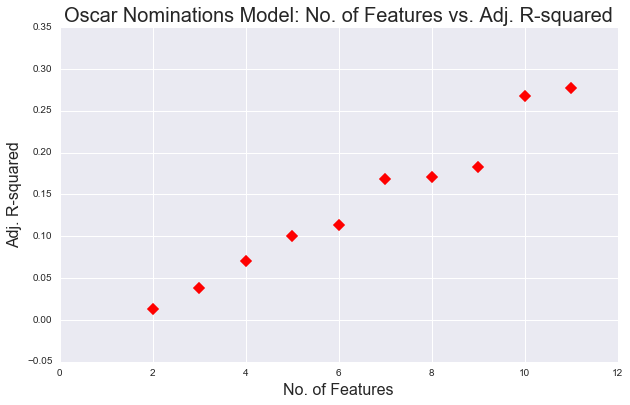

In [2463]:
plt.figure(figsize=(10, 6))
plt.scatter(numfeat_o, rsqs_o, s=70, color='red', marker='D')
plt.title('Oscar Nominations Model: No. of Features vs. Adj. R-squared', fontsize=20)
plt.xlabel('No. of Features', fontsize=16)
plt.ylabel('Adj. R-squared', fontsize=16)
plt.savefig('presentation/oscar-rsq.png')
plt.show()

In [2473]:
# validate
o4 = regress_skl(X, y)
Xval, yval = get_xy(features, ind, val)
o4_resid, o4_mse, o4_ypred = validate(o4, X, y, X, y)

rsquared:  0.311995431073
intercept:  -7.3946485984
train mse:  4.85742020655 vs. val mse:  4.85742020655


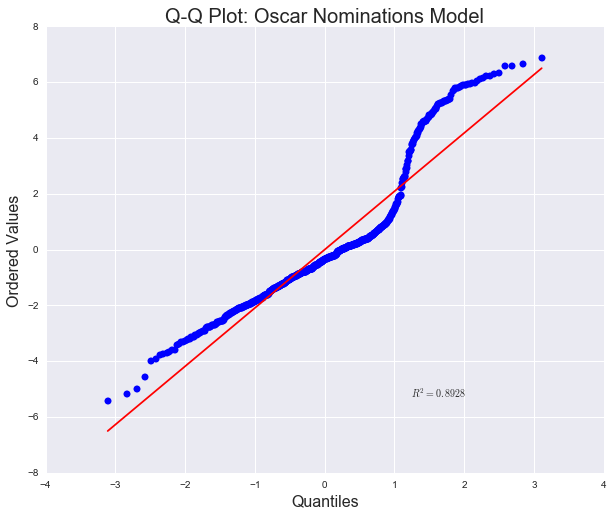

In [2489]:
plt.figure(figsize=(10, 8))
stats.probplot(o4_resid, dist="norm", plot=plt)
plt.title('Q-Q Plot: Oscar Nominations Model', fontsize=20)
plt.xlabel('Quantiles', fontsize=16)
plt.ylabel('Ordered Values', fontsize=16)
plt.savefig('presentation/qq-oscar.png')
plt.show()

In [1926]:
# 4. with log oscar noms, without theaters
oscars4 = smf.ols(formula="oscar_noms_log ~ r_rating + hw_season + runtime_mins + dom_roi_log", 
                 data = train).fit()
oscars4.summary()

NameError: name 'r_rating' is not defined

In [1723]:
# validate
ind = 'oscar_noms_log'
cont_features = ['runtime_mins', 'dom_roi_log']
cat_features = ['hw_season', 'r_rating']

X, y = format_skl(cat_features, cont_features, ind, train)
Xval, yval = format_skl(cat_features, cont_features, ind, val)

oscars4 = regress_skl(X, y)
o4_resid, o4_mse, o4_ypred = validate(oscars4, Xval, yval)

KeyError: ['hw_season', 'r_rating']

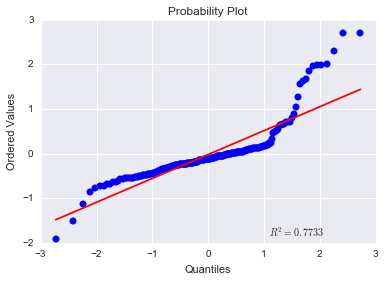

In [1475]:
# qq plot for validation data 
plot_qq(o4_resid)

### set up validation

In [1549]:
keep = ['theaters', 'recat_genre']
tr = train[keep]
pd.get_dummies(tr)

,theaters,recat_genre_Comedy,recat_genre_Crime_Thriller,recat_genre_Drama,recat_genre_Foreign,recat_genre_Historical,recat_genre_Horror,recat_genre_Romance,recat_genre_other
46,2917,1,0,0,0,0,0,0,0
54,1963,1,0,0,0,0,0,0,0
70,672,1,0,0,0,0,0,0,0
123,335,0,0,1,0,0,0,0,0
207,2195,0,0,1,0,0,0,0,0
223,12,0,0,0,0,0,0,0,1
274,1519,0,0,0,0,0,0,0,1
289,16,0,0,0,0,0,0,0,1
303,17,0,0,0,0,0,0,0,1
331,2124,0,0,0,0,0,1,0,0


## older stuff below?

In [ ]:
# old function that gets dummies on independent sets 
def format_skl(features, ind, data):
    '''Format df for use in skl linear regression.
    Args:
    cat_features (list) -- list of column names of categorical features
    cont_features (list) -- list of column names of continuous features
    ind (str) - name of dependent var to predict
    data (df) - dataset to use
    '''
    vals = cat_features + cont_features + [ind] # get list of all columns being used in model
    data.dropna(subset = vals, inplace = True) # drop rows with NaN in any column 
    cats = data[cat_features] # get df with categorial columns
    dummies = pd.get_dummies(cats) # get df with dummies for categorical vars 
    # need to drop one dummy for each cat -- automatically drops anything with "other" 
    keep_dummy = [c for c in dummies.columns if 'other' not in c.lower()] 
    dummies = dummies[keep_dummy]
    conts = data[cont_features]
    X = pd.concat([conts, dummies], axis=1)
    y = data[ind]
    return X, y

#### roi model 1

In [ ]:
roi1 = smf.ols(formula="dom_roi ~ new_genre + theaters + clean_rating + \
                        oscar_noms + director1 + actors1 + writers1 + producers1", 
                  data = train).fit()
roi1.summary()

In [1317]:
ind = 'dom_roi'
cont_features = ['theaters', 'oscar_noms']
cat_features = ['new_genre', 'clean_rating', 'director1', 'actors1', 'writers1', 'producers1']

In [1323]:
X, y = format_skl(cat_features, cont_features, ind, train)
roi1 = regress_skl(X, y)
print '\n'
roi1_lasso = reg_lasso(X, y, 0.5)

rsquared:  0.964062621456
intercept:  1.09722436547


rsquared:  0.139902480827
intercept:  -0.556450965235


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1329]:
X_val, y_val = format_skl(cat_features, cont_features, ind, val)
print X_val.shape
print y_val.shape

(222, 574)
(222,)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1330]:
validate(roi1, X_val, y_val)
# validate(roi1_lasso, X_val, y_val)

ValueError: shapes (222,574) and (1120,) not aligned: 574 (dim 1) != 1120 (dim 0)

In [1010]:
cont_features = ['theaters', 'runtime_mins']
cat_features = ['r_rating', 'hw_season']
ind = 'oscar_noms'

In [1011]:
X, y = format_skl(cat_features, cont_features, ind, train)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1012]:
m2 = regress_skl(X, y)

rsquared:  0.135180564751
intercept:  -1.4885062651
coefs:  [('theaters', 5.8330889720850975e-05), ('runtime_mins', 0.014787553170840023), ('r_rating_R', 0.28340242127491694), ('hw_season_holiday', 0.93526276926526763), ('hw_season_winter', -0.20528240742474166)]


In [1311]:
m2_lasso = reg_lasso(X, y, 0.5)

rsquared:  0.0517292373478
intercept:  -1.25171218882
coefs:  [('theaters', 8.4998165805708866e-06), ('runtime_mins', 0.015768417505900609), ('r_rating_R', 0.0), ('hw_season_holiday', 0.0), ('hw_season_winter', -0.0)]


In [1013]:
# format validation set 
X_val, y_val = format_skl(cat_features, cont_features, ind, val)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### model 2. optimized

In [1038]:
# test cross validation set 
vresid, vmse = validate(m2, X_val, y_val)

In [1039]:
train_resid, train_mse = validate(m2, X, y)

In [1041]:
print vmse, train_mse

2.37069745617 1.55193641358


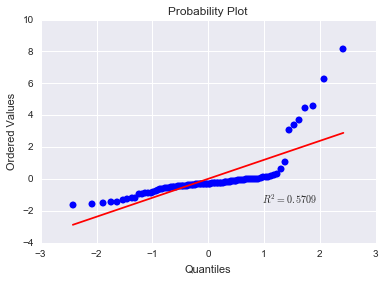

In [1043]:
# qq plot - validation set
stats.probplot(vresid, dist="norm", plot=plt)
plt.show()

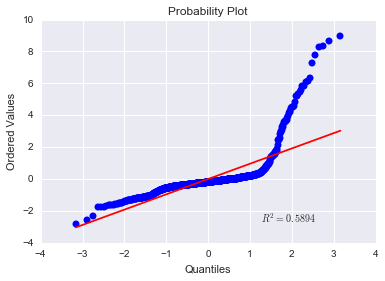

In [1044]:
stats.probplot(train_resid, dist="norm", plot=plt)
plt.show()

(array([ 17.,  64.,   2.,   0.,   1.,   2.,   2.,   0.,   1.,   1.]),
 array([-1.65329376, -0.67272643,  0.3078409 ,  1.28840823,  2.26897556,
         3.24954289,  4.23011022,  5.21067755,  6.19124488,  7.17181221,
         8.15237954]),
 <a list of 10 Patch objects>)

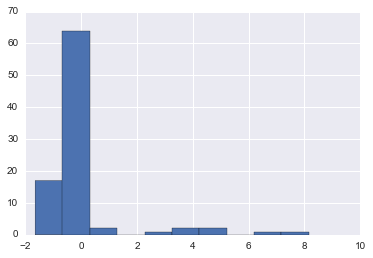

In [1049]:
plt.hist(list(vresid))

#### model 3. oscars log model with theaters

In [1063]:
# train log oscar noms model
ind_log = 'oscar_noms_log'
Xlog, ylog = format_skl(cat_features, cont_features, ind_log, train)
olog_model = regress_skl(Xlog, ylog)

rsquared:  0.154382272501
intercept:  -1.70383649117
coefs:  [('theaters', 3.5662181929102237e-07), ('runtime_mins', 0.0076582484230571669), ('r_rating_R', 0.1542264336259159), ('hw_season_holiday', 0.47984808805320261), ('hw_season_winter', -0.11783258360243239)]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1069]:
# format and test validation set
Xval, yval = format_skl(cat_features, cont_features, ind_log, val)
vresid2, vmse2 = validate(olog_model, Xval, yval)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


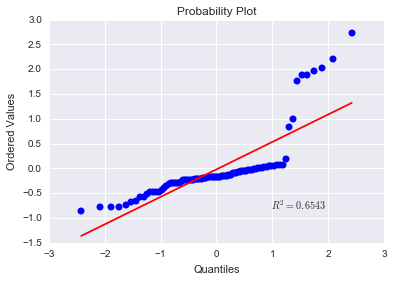

In [1068]:
stats.probplot(vresid2, dist="norm", plot=plt)
plt.show()

In [1072]:
# test on training set 
trresid2, trmse2 = validate(olog_model, Xlog, ylog)

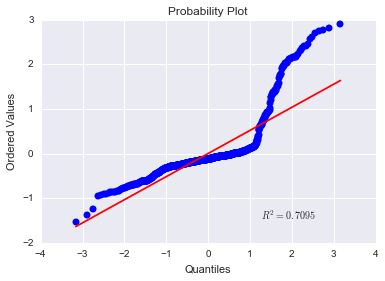

In [1073]:
stats.probplot(trresid2, dist="norm", plot=plt)
plt.show()

In [1080]:
print 'mse of training set: ', trmse2
print 'mse of validation set: ', vmse2

mse of training set:  0.374973511489
mse of validation set:  0.447831746675


#### model 4. oscars log model without theaters

In [1081]:
# X, y 
cont_features4 = ['runtime_mins']
cat_features4 = ['r_rating', 'hw_season']
ind4 = 'oscar_noms_log'

In [1084]:
# format
X_tr4, y_tr4 = format_skl(cat_features4, cont_features4, ind4, train)
X_val4, y_val4 = format_skl(cat_features4, cont_features4, ind4, val)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1085]:
model4 = regress_skl(X_tr4, y_tr4)

rsquared:  0.154381978606
intercept:  -1.7028493958
coefs:  [('runtime_mins', 0.0076538139351256494), ('r_rating_R', 0.15410500078321282), ('hw_season_holiday', 0.47982543874464745), ('hw_season_winter', -0.11776036468517434)]


In [1086]:
resid_tr4, mse_tr4 = validate(model4, X_tr4, y_tr4)
resid_val4, mse_val4 = validate(model4, X_val4, y_val4)

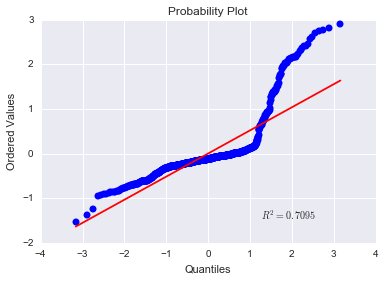

In [1089]:
stats.probplot(resid_tr4, dist="norm", plot=plt)
plt.savefig('model4-qq.png')
plt.show()

In [1087]:
print 'mse of training set: ', mse_tr4
print 'mse of validation set: ', mse_val4

mse of training set:  0.374973641812
mse of validation set:  0.447739874817


#### begin workspace for testing genre categorization

In [18]:
# original genre categories
raw_genres = tuple(by_genre.count().index)
print raw_genres

('Action', 'Action / Adventure', 'Action / Crime', 'Action Comedy', 'Action Drama', 'Action Fantasy', 'Action Horror', 'Action Thriller', 'Adventure', 'Adventure Comedy', 'Animation', 'Comedy', 'Comedy / Drama', 'Comedy Thriller', 'Concert', 'Crime', 'Crime Comedy', 'Crime Drama', 'Crime Thriller', 'Documentary', 'Drama', 'Drama / Thriller', 'Family', 'Family Adventure', 'Family Comedy', 'Fantasy', 'Fantasy Comedy', 'Fantasy Drama', 'Foreign', 'Foreign / Action', 'Foreign / Horror', 'Historical Drama', 'Historical Epic', 'Horror', 'Horror Comedy', 'Horror Thriller', 'IMAX', 'Music Drama', 'Musical', 'None', 'Period Action', 'Period Adventure', 'Period Comedy', 'Period Drama', 'Period Horror', 'Romance', 'Romantic Adventure', 'Romantic Comedy', 'Romantic Thriller', 'Sci-Fi', 'Sci-Fi Action', 'Sci-Fi Adventure', 'Sci-Fi Comedy', 'Sci-Fi Fantasy', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Sports', 'Sports Action', 'Sports Comedy', 'Sports Drama', 'Thriller', 'Unknown', 'War', 'War Drama', 'War

In [33]:
print len(raw_genres)

67


In [626]:
# code simple genres 
simple_genres = ['Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Animation', 'Comedy', 'Comedy', 'Comedy', 'Other', 
                 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 
                 'Documentary', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Foreign', 'Foreign', 'Foreign', 'Historical', 'Historical', 
                 'Horror', 'Horror', 'Horror', 'Other', 'Musical', 'Musical', 'None', 
                 'Historical', 'Historical', 'Historical', 'Historical', 'Historical', 
                 'Romance', 'Romance', 'Romance', 'Romance', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Sports', 'Sports', 'Sports', 'Sports',  'Crime_Thriller', 
                 'None', 'War', 'War', 'War', 'Western', 'Western']

In [627]:
# count how many genres
print set(simple_genres)
print len(set(simple_genres))

set(['Romance', 'None', 'Family', 'Sports', 'Horror', 'Other', 'Act_Adven', 'Foreign', 'Drama', 'Animation', 'War', 'Western', 'Historical', 'Crime_Thriller', 'Fantasy_Scifi', 'Comedy', 'Documentary', 'Musical'])
18


In [628]:
genres = dict(zip(raw_genres, simple_genres))

In [629]:
pprint(genres)

{'Action': 'Act_Adven',
 'Action / Adventure': 'Act_Adven',
 'Action / Crime': 'Act_Adven',
 'Action Comedy': 'Act_Adven',
 'Action Drama': 'Act_Adven',
 'Action Fantasy': 'Act_Adven',
 'Action Horror': 'Act_Adven',
 'Action Thriller': 'Act_Adven',
 'Adventure': 'Act_Adven',
 'Adventure Comedy': 'Act_Adven',
 'Animation': 'Animation',
 'Comedy': 'Comedy',
 'Comedy / Drama': 'Comedy',
 'Comedy Thriller': 'Comedy',
 'Concert': 'Other',
 'Crime': 'Crime_Thriller',
 'Crime Comedy': 'Crime_Thriller',
 'Crime Drama': 'Crime_Thriller',
 'Crime Thriller': 'Crime_Thriller',
 'Documentary': 'Documentary',
 'Drama': 'Drama',
 'Drama / Thriller': 'Drama',
 'Family': 'Family',
 'Family Adventure': 'Family',
 'Family Comedy': 'Family',
 'Fantasy': 'Fantasy_Scifi',
 'Fantasy Comedy': 'Fantasy_Scifi',
 'Fantasy Drama': 'Fantasy_Scifi',
 'Foreign': 'Foreign',
 'Foreign / Action': 'Foreign',
 'Foreign / Horror': 'Foreign',
 'Historical Drama': 'Historical',
 'Historical Epic': 'Historical',
 'Horror': '

#### </ end genre testing workspace >

In [93]:
pd.get_dummies(newer_movies, columns = ['genre']).head()

,1-title,2-release_date,3-closing_date,actors,budget,director,distributor,dom_total_gross,intl_total_gross,oscar_noms,...,genre_Romantic Thriller,genre_Sci-Fi Action,genre_Sci-Fi Horror,genre_Sci-Fi Thriller,genre_Sports Comedy,genre_Sports Drama,genre_Thriller,genre_Unknown,genre_War,genre_Western
123,Affliction,1998-12-30,NaT,[Willem Dafoe],6000000,[Paul Schrader],Lions Gate,6330054,NaN,2,...,0,0,0,0,0,0,0,0,0,0
200,Airplane!,1980-06-27,NaT,[Leslie Nielsen],3500000,"[Jim Abrahams, David Zucker, Jerry Zucker]",Paramount,83453539,NaN,0,...,0,0,0,0,0,0,0,0,0,0
207,Akeelah and the Bee,2006-04-28,2006-07-20,"[Laurence Fishburne, Angela Bassett, Keke Palmer]",8000000,None,Lionsgate,18848430,18948425,0,...,0,0,0,0,0,0,0,0,0,0
223,Albino Alligator,1997-01-17,1997-02-13,"[Matt Dillon, Viggo Mortensen]",6000000,None,Miramax,339379,NaN,0,...,0,0,0,0,0,0,0,1,0,0
289,All or Nothing,2002-10-25,NaT,"[Taraji P. Henson, Sally Hawkins]",9000000,[Mike Leigh],United Artists,201546,201546,0,...,0,0,0,0,0,0,0,1,0,0
